In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
from model.locator import Locator
import torchcde
import MulensModel as mm
from model.utils import simulate_lc
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

In [9]:
rmse_list = []
rmse_lgte_list = []
rmse_t0te_list = []
for noise, SN in tqdm([(0.1, 10), (0.03, 33), (0.01, 100), (0.003, 333), (0.001, 1000)]):
    with h5py.File(f'/work/hmzhao/irregular-lc/KMT-locflux-{noise}-0.h5', mode='r') as dataset_file:
        Y = torch.tensor(dataset_file['Y'][...])
        X = torch.tensor(dataset_file['X'][...])
    nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
    Y = Y[nanind]
    X = X[nanind]
    Y = Y[:, [0, 1, -1]]

    # discard uncertainty bar
    X = X[:, :, :2]
    Y = Y[:, [0, 1]]
    train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X)

    method = 'avg'
    k = 1/3
    checkpt = torch.load(f'/work/hmzhao/experiments/locator/experiment_SN{SN}.ckpt', map_location='cpu')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    ckpt_args = checkpt['args']
    state_dict = checkpt['state_dict']

    model = Locator(device, k=k, method=method).to(device)
    model_dict = model.state_dict()

    # 1. filter out unnecessary keys
    state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(state_dict) 
    # 3. load the new state dict
    model.load_state_dict(state_dict)
    model.to(device)
    
    num = 4096*4
    batchsize = 128
    pred = torch.zeros((num, 2))
    y_ref = torch.zeros((batchsize, 2)).to(device)
    z = torch.zeros((num, 4000, 2))
    model.eval()
    model.plot = False
    model.soft_threshold = True
    model.threshold = 0.5
    model.animate = True
    with torch.no_grad():
        for i in tqdm(range(num // batchsize), leave=False):
            batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
            y_ref = Y[i*batchsize:i*batchsize+batchsize].float().to(device)
            res = model(batch, y_ref)
            pred[i*batchsize:i*batchsize+batchsize] = res[0].detach().cpu()
            z[i*batchsize:i*batchsize+batchsize] = res[2].detach().cpu()
    rmse = torch.sqrt(torch.mean((pred - Y[:num])**2, dim=0))
    rmse_list.append(rmse)
    rmse_lgte = torch.sqrt(torch.mean((np.log10(pred[:, 1]) - np.log10(Y[:num, 1]))**2))
    rmse_lgte_list.append(rmse_lgte)
    rmse_t0te = torch.sqrt(torch.mean((pred[:, 0]/pred[:, 1] - Y[:num, 0]/Y[:num, 1])**2))
    rmse_t0te_list.append(rmse_t0te)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

In [10]:
rmse_list = torch.stack(rmse_list)

In [11]:
np.save('rmse_SN.npy', rmse_list.numpy())

In [2]:
rmse_SN = np.load('rmse_SN.npy')
rmse_SN10 = np.load('rmse_SN10.npy')
rmse_SN1000 = np.load('rmse_SN1000.npy')

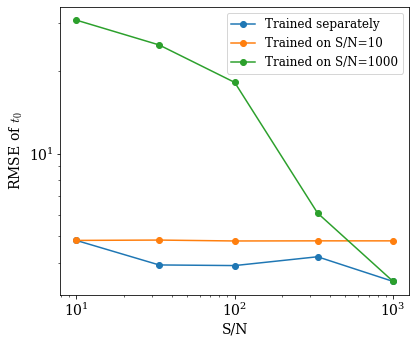

In [4]:
fig = plt.figure(figsize=(6, 5))
noise = np.array([0.1, 0.03, 0.01, 0.003, 0.001])
plt.plot(1/noise, rmse_SN[:, 0], label=r'Trained separately', marker='o')
plt.plot(1/noise, rmse_SN10[:, 0], label=r'Trained on S/N=10', marker='o')
plt.plot(1/noise, rmse_SN1000[:, 0], label=r'Trained on S/N=1000', marker='o')
# plt.plot(1/noise, 1.1e2*noise**0.5, linestyle='dashed', color='black')
plt.legend(loc='upper right', prop={'size': 12})
plt.xlabel('S/N')
# plt.xticks(np.arange(5), [10, 33, 100, 333, 1000])
plt.xscale('log')
plt.ylabel(r'RMSE of $t_0$')
plt.yscale('log')
plt.tight_layout()
plt.savefig('./noise.pdf')
plt.show()

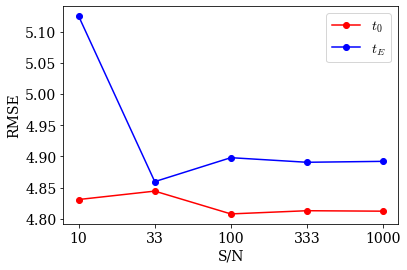

In [15]:
plt.plot(rmse_list[:, 0], color='red', label=r'$t_0$', marker='o')
plt.plot(rmse_list[:, 1], color='blue', label=r'$t_E$', marker='o')
plt.legend(loc='upper right')
plt.xlabel('S/N')
plt.xticks(np.arange(5), [10, 33, 100, 333, 1000])
plt.ylabel('RMSE')
plt.show()
# plt.plot(rmse_lgte_list, color='green', label=r'$\lg t_E$', marker='o')
# plt.twinx()
# plt.plot(rmse_t0te_list, color='orange', label=r'$t_0/t_E$', marker='o')
# plt.legend(loc='lower left')
# plt.xlabel('S/N')
# plt.xticks(np.arange(5), [10, 33, 100, 333, 1000])
# plt.ylabel('RMSE')

# plt.show()

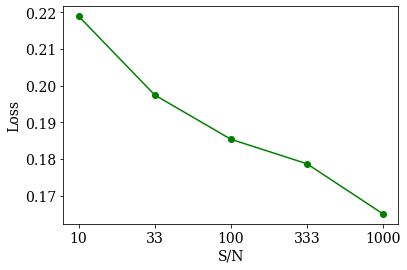

In [69]:
plt.plot([0.21897, 0.19746, 0.18538, 0.17869, 0.16499], color='green', marker='o')
# plt.legend(loc='upper right')
plt.xlabel('S/N')
plt.xticks(np.arange(5), [10, 33, 100, 333, 1000])
plt.ylabel('Loss')
plt.show()

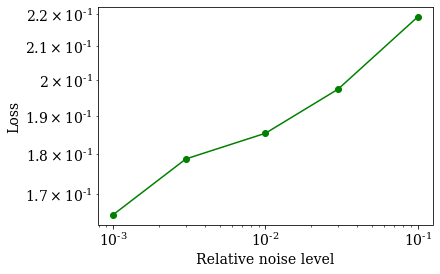

In [71]:
plt.plot([0.1, 0.03, 0.01, 0.003, 0.001], [0.21897, 0.19746, 0.18538, 0.17869, 0.16499], color='green', marker='o')
plt.xscale('log')
plt.yscale('log')
# plt.legend(loc='upper left')
plt.xlabel('Relative noise level')
plt.ylabel('Loss')
plt.show()

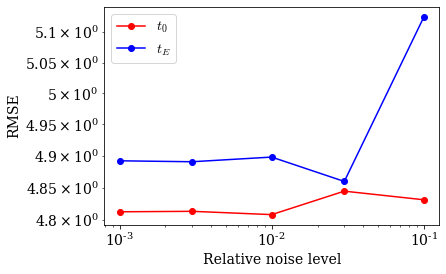

In [16]:
plt.plot([0.1, 0.03, 0.01, 0.003, 0.001], rmse_list[:, 0], color='red', label=r'$t_0$', marker='o')
plt.plot([0.1, 0.03, 0.01, 0.003, 0.001], rmse_list[:, 1], color='blue', label=r'$t_E$', marker='o')
# plt.plot([0.1, 0.03, 0.01, 0.003, 0.001], rmse_lgte_list, color='green', label=r'$\lg t_E$', marker='o')
# plt.plot([0.1, 0.03, 0.01, 0.003, 0.001], rmse_t0te_list, color='orange', label=r'$t_0/t_E$', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left')
plt.xlabel('Relative noise level')
plt.ylabel('RMSE')
plt.show()

In [8]:
from sklearn.linear_model import LinearRegression

reg_t0 = LinearRegression().fit(np.log10(np.array([0.1, 0.03, 0.01, 0.003, 0.001])).reshape(-1, 1), np.log10(rmse_list[:, [0]]))
reg_te = LinearRegression().fit(np.log10(np.array([0.1, 0.03, 0.01, 0.003, 0.001])).reshape(-1, 1), np.log10(rmse_list[:, [1]]))
reg_loss = LinearRegression().fit(np.log10(np.array([0.1, 0.03, 0.01, 0.003, 0.001])).reshape(-1, 1), np.log10([0.21897, 0.19746, 0.18538, 0.17869, 0.16499]).reshape(-1, 1))
# reg_lgte = LinearRegression().fit(np.log10(np.array([0.1, 0.03, 0.01, 0.003, 0.001])).reshape(-1, 1), np.log10(rmse_lgte_list).reshape(-1, 1))
# reg_t0te = LinearRegression().fit(np.log10(np.array([0.1, 0.03, 0.01, 0.003, 0.001])).reshape(-1, 1), np.log10(rmse_t0te_list).reshape(-1, 1))

In [9]:
reg_loss.coef_, reg_loss.intercept_, reg_loss.score(np.log10(np.array([0.1, 0.03, 0.01, 0.003, 0.001])).reshape(-1, 1), np.log10([0.21897, 0.19746, 0.18538, 0.17869, 0.16499]).reshape(-1, 1))

(array([[0.05784865]]), array([-0.60907641]), 0.9755803826854565)

In [10]:
reg_t0.coef_, reg_t0.intercept_, reg_t0.score(np.log10(np.array([0.1, 0.03, 0.01, 0.003, 0.001])).reshape(-1, 1), np.log10(rmse_list[:, [0]]))

(array([[0.50427411]]), array([2.10617084]), 0.9283815370009031)

In [11]:
reg_te.coef_, reg_te.intercept_, reg_te.score(np.log10(np.array([0.1, 0.03, 0.01, 0.003, 0.001])).reshape(-1, 1), np.log10(rmse_list[:, [1]]))

(array([[0.49262051]]), array([2.04485488]), 0.9497920687711213)

In [49]:
reg_lgte.coef_, reg_lgte.intercept_

(array([[0.46812573]]), array([0.25559767]))

In [50]:
reg_t0te.coef_, reg_t0te.intercept_

(array([[0.33365702]]), array([0.4313245]))